In [9]:
%reload_ext autoreload
%autoreload 2

import sys
import os 
import pandas as pd 
import numpy as np
import utils 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
import dask.dataframe as dd
import time
%matplotlib inline

In [2]:
#at home
#os.chdir("/media/brehelin/0FECCBDE10E4BE99/Kaggle/Data")
#at aws
os.chdir("/home/ec2-user/data")

In [3]:
ls

aisles.csv*                 order_products__train.csv*  sample_submission.csv*
departments.csv*            orders.csv*
order_products__prior.csv*  products.csv*


In [3]:
aisles = pd.read_csv("aisles.csv")
departements = pd.read_csv("departments.csv")
order_products__prior = pd.read_csv("order_products__prior.csv")
order_products__train = pd.read_csv("order_products__train.csv")
order = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
sample_submission = pd.read_csv("sample_submission.csv")

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.
File descriptions

Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

order_products__.csv

These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

orders.csv

This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

## Description tables

In [5]:
#aisles
utils.descr(aisles)

(134, 2)
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


In [6]:
#departements
utils.descr(departements)

(21, 2)
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [7]:
utils.descr(order_products__prior)
print("Nb de commande unique : ", len(np.unique(order_products__prior["order_id"])))

(32434489, 4)
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
Nb de commande unique :  3214874


In [8]:
utils.descr(order_products__train)
print("Nb de commande unique : ", len(np.unique(order_products__train["order_id"])))

(1384617, 4)
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
Nb de commande unique :  131209


In [9]:
order_products__train.ix[ order_products__train["order_id"]==1, :]

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1


In [10]:
np.unique(order_products__prior["order_id"])

array([      2,       3,       4, ..., 3421081, 3421082, 3421083])

In [11]:
np.unique(order_products__train["order_id"])

array([      1,      36,      38, ..., 3421058, 3421063, 3421070])

A priori pas les même commandes dans prior et dans le train

In [12]:
utils.descr(order)
print("Nb user unique : ", len(np.unique(order["user_id"])))
print("Nb ID order unique : ", len(np.unique(order["order_id"])))
print("Nb order unique : ", len(np.unique(order["order_number"])))

(3421083, 7)
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
Nb user unique :  206209
Nb ID order unique :  3421083
Nb order unique :  100


In [13]:
#reorder
#order_dow
131209 + 3214874

3346083

## Stat descriptive order et création test&train

In [14]:
order.ix[ order["user_id"]==5, :]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
45,2717275,5,prior,1,3,12,NaN
46,1909121,5,prior,2,0,16,11.0
47,2267326,5,prior,3,3,18,10.0
48,157374,5,prior,4,1,18,19.0
49,2196797,5,train,5,0,11,6.0


In [15]:
np.unique(order["eval_set"])

array(['prior', 'test', 'train'], dtype=object)

In [16]:
# créer un data train et de test

In [17]:
test_data = order.groupby('user_id').eval_set.value_counts().unstack()
test_data = test_data.fillna(0)

In [18]:
np.mean(test_data["prior"])

15.590367054784224

In [129]:
test_data.head()

eval_set,prior,test,train
user_id,,,
1,10.0,0.0,1.0
2,14.0,0.0,1.0
3,12.0,1.0,0.0
4,5.0,1.0,0.0
5,4.0,0.0,1.0


In [130]:
print("Train Data")
print(test_data.loc[test_data["test"]==0, "prior"].min())
print(test_data.loc[test_data["test"]==0, "prior"].max())

print("Test Data")
print(test_data.loc[test_data["test"]==1, "prior"].min())
print(test_data.loc[test_data["test"]==1, "prior"].max())

Train Data
3.0
99.0
Test Data
3.0
99.0


In [20]:
Counter(test_data["test"] == test_data["train"]) 
# Chaque user_id est donc soit train soit test

Counter({False: 206209})

In [21]:
test_data.iloc[206208,:]


eval_set
prior    13.0
test      0.0
train     1.0
Name: 206209, dtype: float64

In [22]:
id_train = []
id_test = []
for i in range(test_data.shape[0]):
    if test_data.iloc[i, 2]==1:
        id_train.append(test_data.iloc[i, :].name)
    else:
        id_test.append(test_data.iloc[i, :].name)


In [27]:
print("Nombre de user dans le train : ",utils.likely_format(len(id_train)))
print("Nombre de user dans le test : ", utils.likely_format(len(id_test)))

Nombre de user dans le train :  131 209
Nombre de user dans le test :  75 000


* Test équivalent à submission, les commandes des user_id présent dans le test seront les produits à prédire

In [43]:
df_train_order = order[order["user_id"].isin(id_train)]
df_test_order = order[order["user_id"].isin(id_test)]

In [25]:
print("Dimension train : ", utils.likely_format(df_train_order.shape[0]))
print("Dimension test : ",  utils.likely_format(df_test_order.shape[0]))

Dimension train :  2 178 586
Dimension test :  1 242 497


In [35]:
# On fixe les nan de days_since_prior_order à -1 pour l'instant
#df_train_order["days_since_prior_order"].fillna(-1, inplace=True)
#df_test_order["days_since_prior_order"].fillna(-1, inplace=True)

/home/brehelin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


**Stat descriptive** 

In [41]:
# nombre de commande moyenne
print("Nombre moyen de commande par user sur le TRAIN : ")
print(df_train_order.groupby(["user_id"]).last()["order_number"].mean())

print("Nombre moyen de commande par user sur le TESST : ")
print(df_test_order.groupby(["user_id"]).last()["order_number"].mean())

Nombre moyen de commande par user sur le TRAIN : 
16.60393722991563
Nombre moyen de commande par user sur le TESST : 
16.566626666666668


In [45]:
# Délai moyen entre les commandes
meanTime_user_train = df_train_order.groupby(["user_id"])["days_since_prior_order"].mean()
meanTime_user_test = df_test_order.groupby(["user_id"])["days_since_prior_order"].mean()

print("Délai moyen des commandes sur le TRAIN : ")
print(meanTime_user_train.mean())

print("Délai moyen des commandes sur le TESST : ")
print(meanTime_user_test.mean())

Délai moyen des commandes sur le TRAIN : 
15.445032799596085
Délai moyen des commandes sur le TESST : 
15.455077983902495


* Remarque prédiction : évidemment si commande espacé de moins que la moyenne possiblement on oublie et donc pas de reoder ==> a verifier ??
ou pas un jour habituel pour le client

In [70]:
np.unique(df_train_order["order_dow"])
# Donc mercredi = 2

array([0, 1, 2, 3, 4, 5, 6])

In [66]:
df_train_order.groupby(["user_id"])["order_dow", "order_hour_of_day"].mean().mean()

order_dow             2.753508
order_hour_of_day    13.585900
dtype: float64

In [71]:
df_train_order.groupby(["user_id"])["order_dow", "order_hour_of_day"].mean().std()

order_dow            0.894135
order_hour_of_day    2.021516
dtype: float64

In [67]:
df_train_order.groupby(["user_id"])["order_dow", "order_hour_of_day"].std().mean()

order_dow            1.904035
order_hour_of_day    3.631895
dtype: float64

* Valeur équivalente sur le test 

Sur df order distribution équivalente entre train & test

order_number


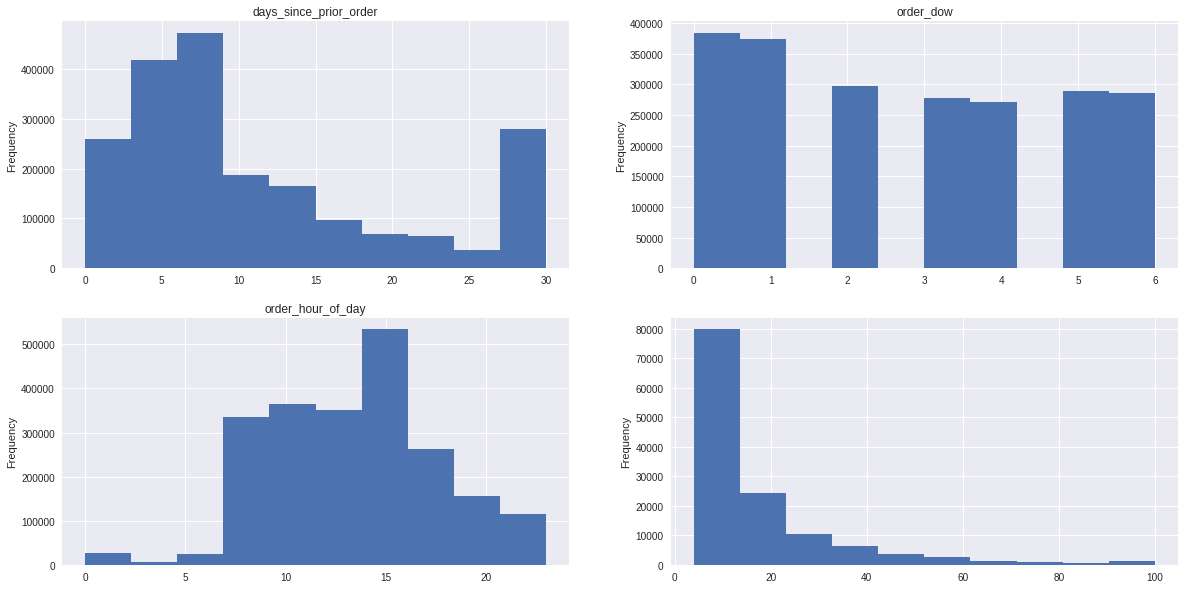

In [98]:
# Plot en volume et non par clients
plt.figure(figsize=(20, 10))
plt.subplot(221)
df_train_order["days_since_prior_order"].plot.hist()
plt.title("days_since_prior_order")
plt.subplot(222)
df_train_order["order_dow"].plot.hist()
plt.title("order_dow")
plt.subplot(223)
df_train_order["order_hour_of_day"].plot.hist()
plt.title("order_hour_of_day")
plt.subplot(224)
df_train_order.groupby(["user_id"]).last()["order_number"].plot.hist()
print("order_number")
plt.show()

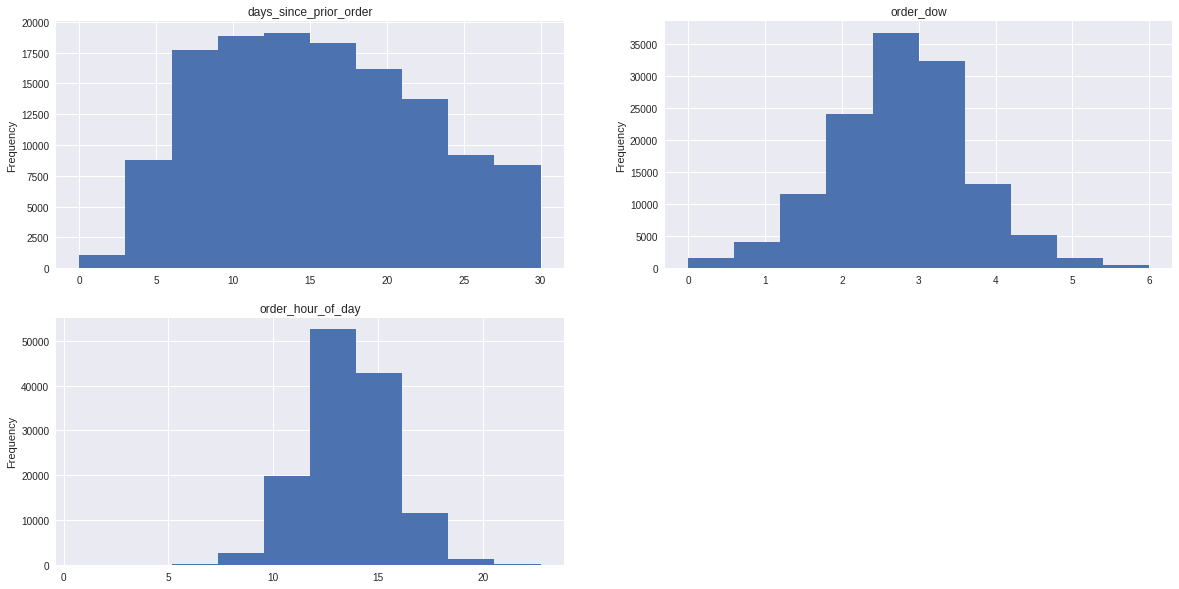

In [96]:
# vision clients
plt.figure(figsize=(20, 10))
plt.subplot(221)
df_train_order.groupby(["user_id"])["days_since_prior_order"].mean().plot.hist()
plt.title("days_since_prior_order")
plt.subplot(222)
df_train_order.groupby(["user_id"])["order_dow"].mean().plot.hist()
plt.title("order_dow")
plt.subplot(223)
df_train_order.groupby(["user_id"])["order_hour_of_day"].mean().plot.hist()
plt.title("order_hour_of_day")
plt.show()

## Stat descriptive order products

stat descriptive order products donc faire un concat entre le train et le prior

1. Le nombre de produit commandé par commande
2. Le nombre de reoder par commande 
3. Nombre produit/ nombre reoder selon le jour l'heure et l'espacement avec précédente commande
4. Le type de produit reoder 
5. le taux de reordered
6. le type de produit reoder selon le jour l'heure et l'espacement avec précédente commande

=> faire ses stats avec le merge du train et du prior  
=> faire ses stats que sur le prior

faire des stats sur le lien entre le train et le order 

In [11]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### a) stats only on prior dataset

In [13]:
order_products__prior.groupby(["order_id"])["product_id"].count().describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

In [14]:
order_products__prior.groupby(["order_id"])["reordered"].sum().describe()
# Dans le prior on a evidemment dans les commandes sans prior, a verifier avec un merge ?

count    3.214874e+06
mean     5.949389e+00
std      5.842059e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.300000e+02
Name: reordered, dtype: float64

In [16]:
merge_order_product = pd.merge(order_products__prior, order, on="order_id")

In [17]:
merge_order_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


### Clustering 

In [18]:
merge_order_product = merge_order_product[["product_id", "reordered", "order_number", "order_dow", "order_hour_of_day","days_since_prior_order"]]
merge_order_product = merge_order_product[merge_order_product["order_number"]<=3]

In [41]:
#products_order["order_hour_of_day"].hist(bins=24)
# 0- 7 
# 7 - 10
# 10 - 17
# 17 - 20
# 20- 24
#products_order["order_dow"].hist(bins=6)
# 0 & 6
# 1 - 2
# 3-4-5

In [19]:
merge_order_product.shape

(6177131, 6)

In [20]:
# order_hour_of_day
merge_order_product["order_dow_0&6"] = merge_order_product["order_dow"].map(lambda x : 1 if x==0 | x==6 else 0)

# order_dow
merge_order_product["order_dow_0&6"] = merge_order_product["order_dow"].map(lambda x : 1 if x==0 | x==6 else 0)
merge_order_product["order_dow_1_2"] = merge_order_product["order_dow"].map(lambda x : 1 if x==1 | x==2 else 0)
merge_order_product["order_dow_1_2_3"] = merge_order_product["order_dow"].map(lambda x : 1 if x==3 | x==4 | x==5 else 0)
del merge_order_product["order_dow"]

In [21]:
merge_order_product.head()

,product_id,reordered,order_number,order_hour_of_day,days_since_prior_order,order_dow_0&6,order_dow_1_2,order_dow_1_2_3
0,33120,1,3,9,8.0,0,0,0
1,28985,1,3,9,8.0,0,0,0
2,9327,0,3,9,8.0,0,0,0
3,45918,1,3,9,8.0,0,0,0
4,30035,0,3,9,8.0,0,0,0
